# Sector Life Metrics Dashboard

## Setting-up

In [1]:
%load_ext autotime

%load_ext autoreload

%autoreload 2

time: 34.4 ms (started: 2021-02-17 17:07:16 -03:00)


In [2]:
# External depences
import pandas as pd
import numpy as np
import plotly.express as px

# Move path to parent folder
import sys
sys.path.insert(1, '../')

# Internal dependences
from filecoin_metrics.connection import get_connection, get_connection_string
from filecoin_metrics.metrics import *


time: 2.62 s (started: 2021-02-17 17:07:18 -03:00)


In [3]:
conn_string = get_connection_string('../config/sentinel-conn-string.txt')
connection = get_connection(conn_string)


time: 23.4 s (started: 2021-02-17 17:07:20 -03:00)


## Visualizations

### Expiration vs Activation Week

In [4]:
df = sector_activation_and_expiration_by_week(connection)

time: 4min 56s (started: 2021-02-17 17:07:44 -03:00)


In [5]:
fig_df = (df.reset_index()
            .assign(sqrt_sector_count=lambda df: df.sector_count ** (1 / 3))
            .assign(log_sector_count=lambda df: np.log(df.sector_count))
            .assign(sector_lifetime_days=lambda df: (df.expiration_week - df.activation_week).dt.days)
            )

time: 25.5 ms (started: 2021-02-17 17:15:23 -03:00)


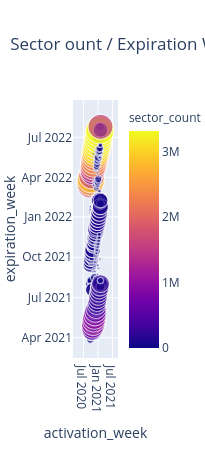

time: 328 ms (started: 2021-02-17 17:15:24 -03:00)


In [6]:
fig = px.scatter(fig_df,
                 x='activation_week',
                 y='expiration_week',
                 size='sqrt_sector_count',
                 color='sector_count',
                 title='Sector ount / Expiration Week grouped by Activation Week')
fig.show()

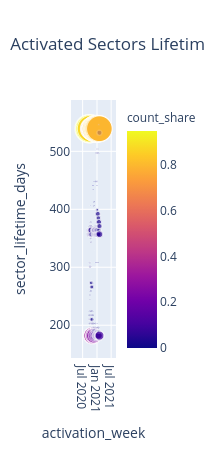

time: 278 ms (started: 2021-02-17 17:23:47 -03:00)


In [14]:
s = fig_df.groupby('activation_week').apply(lambda df: df.sector_count / df.sector_count.sum())
s.name = 'count_share'

z_df = fig_df.assign(count_share=s.values)

fig = px.scatter(z_df,
                 x='activation_week',
                 y='sector_lifetime_days',
                 size='count_share',
                 color='count_share',
                 title='Activated Sectors Lifetime across Time (weekly)')
fig.show()


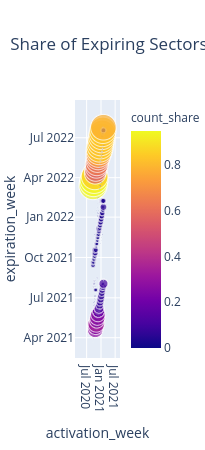

time: 403 ms (started: 2021-02-17 17:23:50 -03:00)


In [15]:
s = fig_df.groupby('activation_week').apply(lambda df: df.sector_count / df.sector_count.sum())
s.name = 'count_share'

z_df = fig_df.assign(count_share=s.values)

fig = px.scatter(z_df,
                 x='activation_week',
                 y='expiration_week',
                 size='count_share',
                 color='count_share',
                 title='Share of Expiring Sectors grouped per Activation Week')
fig.show()

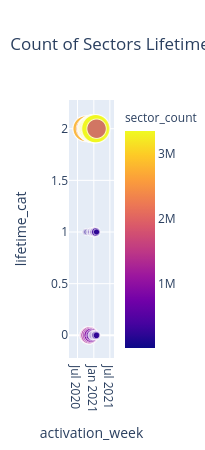

time: 300 ms (started: 2021-02-17 17:23:50 -03:00)


In [16]:
categories = pd.cut(fig_df.sector_lifetime_days, bins=3, labels=False)
z_df = fig_df.assign(lifetime_cat=categories)
z_df = z_df.groupby(['lifetime_cat', 'activation_week']).sector_count.sum().reset_index()
px.scatter(z_df,
           x='activation_week',
           y='lifetime_cat',
           size='sector_count',
           color='sector_count',
           title='Count of Sectors Lifetime Category grouped by Activation Week')

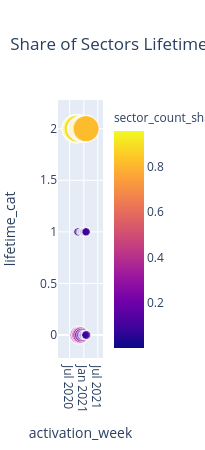

time: 332 ms (started: 2021-02-17 17:23:51 -03:00)


In [17]:
categories = pd.cut(fig_df.sector_lifetime_days, bins=3, labels=False)
z_df = fig_df.assign(lifetime_cat=categories)
z_df = z_df.groupby(['lifetime_cat', 'activation_week']).sector_count.sum().reset_index()
z_df = z_df.set_index('lifetime_cat').groupby(['activation_week']).apply(lambda x: x.sector_count / x.sector_count.sum()).unstack().reset_index().rename(columns={0: 'sector_count_share'})
fig = px.scatter(z_df,
           x='activation_week',
           y='lifetime_cat',
           size='sector_count_share',
           color='sector_count_share',
           title='Share of Sectors Lifetime Category grouped by Activation Week')
fig.show()

## Upcoming sector expiration, monthly, network-wide

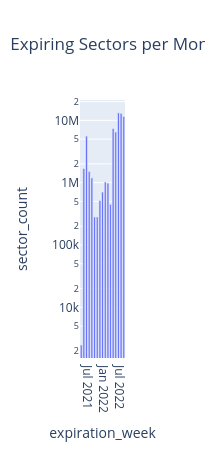

time: 94.1 ms (started: 2021-02-17 17:31:31 -03:00)


In [24]:
z_df = fig_df.groupby('expiration_week').sector_count.sum()
z_df = z_df.resample('1m').sum().reset_index()

px.bar(z_df,
        x='expiration_week',
        y='sector_count',
        title='Expiring Sectors per Month',
        log_y=True,
        labels={'value': 'Sectors',
                'time': 'Timestamp'})

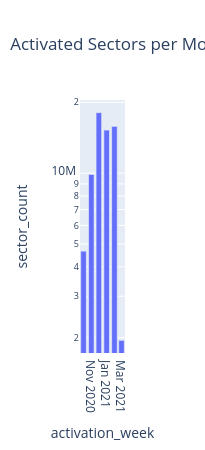

time: 116 ms (started: 2021-02-17 17:31:20 -03:00)


In [23]:
z_df = fig_df.groupby('activation_week').sector_count.sum()
z_df = z_df.resample('1m').sum().reset_index()

px.bar(z_df,
        x='activation_week',
        y='sector_count',
        title='Activated Sectors per Month',
        log_y=True,
        labels={'value': 'Sectors',
                'time': 'Timestamp'})